In [2]:
import pandas as pd
file_path = r'/kaggle/input/wallets_features_classes_combined.csv'
df_wallets_features_classes_combined = pd.read_csv(file_path)

In [3]:
import optuna

In [4]:
# 2. Preprocess data
df_wallets_classification = df_wallets_features_classes_combined.drop(columns=['Time step']).drop_duplicates()
data = df_wallets_classification.loc[(df_wallets_classification['class'] != 3), 'address']
df_wallets_feature_selected = df_wallets_classification.loc[df_wallets_classification['address'].isin(data)]

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone 
import xgboost as xgb
from sklearn.base import clone
import numpy as np

In [6]:
# Define X and y
y = df_wallets_feature_selected[['class']]
y = y['class'].apply(lambda x: 0 if x == 2 else 1 )
X = df_wallets_feature_selected.drop(columns=['address', 'class'])

# Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [7]:
X_train.sample(3)

,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,num_timesteps_appeared_in,btc_transacted_total,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
748623,1.0,0.0,463776.0,463776.0,0.0,1.0,463776.0,0.0,1.0,0.403013,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0
712851,1.0,0.0,429504.0,429504.0,0.0,1.0,429504.0,0.0,1.0,0.000037,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0
327564,1.0,0.0,403305.0,403305.0,0.0,1.0,403305.0,0.0,1.0,0.005100,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0


In [8]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#Flatten into 1 dimension array cuz scikit-learn & f1-score needs
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [9]:
X_test_scaled.sample(3)

,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,num_timesteps_appeared_in,btc_transacted_total,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
21435,0.000688,0.000000,0.708303,0.708303,0.00000,0.00000,0.942151,0.000000,0.0,3.493565e-08,...,0.0,0.0,0.0,0.0,0.0,0.000026,0.0,0.0,0.0,0.0
36642,0.000688,0.001862,0.645859,0.645869,0.00001,0.00068,0.929769,0.929767,0.0,1.364760e-03,...,0.0,0.0,0.0,0.0,0.0,0.000053,0.0,0.0,0.0,0.0
70381,0.000000,0.001862,0.291687,0.291687,0.00000,0.00000,0.000000,0.859528,0.0,1.700514e-06,...,0.0,0.0,0.0,0.0,0.0,0.000396,0.0,0.0,0.0,0.0


In [10]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
y_test

array([0, 1, 0, ..., 0, 0, 0])

## Retrain model

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    precision_recall_fscore_support,
    f1_score,
    accuracy_score,
    classification_report,
    roc_auc_score
)

In [13]:
def evaluate_model(model_name, y_true, y_pred, y_proba=None):
    # Basic metrics for class 1 (positive class)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    # ROC AUC - Good for class imbalance.
    roc_auc = None
    if y_proba is not None and len(set(y_true)) == 2:
        roc_auc = roc_auc_score(y_true, y_proba)

    # Print section
    print(f"\n {model_name} Evaluation Results:")
    
    if roc_auc is not None:
        print("ROC AUC: %.6f" % roc_auc)
        
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3))

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
evaluate_model("Random Forest", y_test, y_pred_rf)


 Random Forest Evaluation Results:

Classification Report:
              precision    recall  f1-score   support

           0      0.992     0.997     0.995     76718
           1      0.921     0.790     0.850      2889

    accuracy                          0.990     79607
   macro avg      0.956     0.893     0.922     79607
weighted avg      0.990     0.990     0.990     79607



In [15]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
evaluate_model("XGBoost", y_test, y_pred_xgb)


 XGBoost Evaluation Results:

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.996     0.994     76718
           1      0.888     0.809     0.846      2889

    accuracy                          0.989     79607
   macro avg      0.940     0.902     0.920     79607
weighted avg      0.989     0.989     0.989     79607



# Use best model for feature selection

## PFI (Permutation feature importance)

In [16]:
import eli5
from eli5.sklearn import PermutationImportance as PI
from sklearn.base import clone
# PFI Calculations
perm_rf = PI(rf, random_state=42).fit(X_test_scaled, y_test)
pfi_rf_df = eli5.explain_weights_df(perm_rf, feature_names=X_test_scaled.columns.tolist())
pfi_rf_df = pfi_rf_df[['feature', 'weight']].rename(columns={'weight': 'weight_rf'})

2025-06-05 07:13:14.099518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749107594.347360      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749107594.420814      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
pfi_rf_df = pfi_rf_df[['feature', 'weight_rf']].rename(columns={'feature': 'Feature'})

In [18]:
pfi_rf_df.head(20)

,Feature,weight_rf
0,transacted_w_address_total,0.005565
1,fees_min,0.001924
2,fees_as_share_max,0.001774
3,first_sent_block,0.001759
4,fees_max,0.001560
5,first_received_block,0.001497
6,last_block_appeared_in,0.000859
7,first_block_appeared_in,0.000842
8,fees_total,0.000618
9,fees_median,0.000560


## DCFI (Drop Column Feature Importance)

In [19]:
# X_train_full, y_train_full is the full training dataset (Scaled)
# X_eval, y_eval is the full testing dataset (Scaled)
def compute_dcfi_rf_only(model_template, X_train_full, y_train_full, X_eval, y_eval, random_state=42):
    
    y_train_array = y_train_full.ravel()
    y_eval_array = y_eval.ravel()

    #Clone the root model 
    model_clone_benchmark = clone(model_template)
    if hasattr(model_clone_benchmark, 'random_state'):
        model_clone_benchmark.random_state = random_state

    # Convert to numpy array if needed
    X_train_full_array = X_train_full.values if isinstance(X_train_full, pd.DataFrame) else X_train_full
    X_eval_array = X_eval.values if isinstance(X_eval, pd.DataFrame) else X_eval

    # Train the model using all features from training data
    model_clone_benchmark.fit(X_train_full_array, y_train_array)
    y_pred_benchmark = model_clone_benchmark.predict(X_eval_array)
    benchmark_score = f1_score(y_eval_array, y_pred_benchmark, pos_label=1, average='binary')

    importances = []
    features = X_train_full.columns.tolist() if isinstance(X_train_full, pd.DataFrame) else [f'Feature_{i}' for i in range(X_train_full_array.shape[1])]

    for i in range(X_train_full_array.shape[1]):
        # Assign exactly the random_state initialized be4
        model_clone_drop = clone(model_template)
        if hasattr(model_clone_drop, 'random_state'):
            model_clone_drop.random_state = random_state

        X_train_subset_array = np.delete(X_train_full_array, i, axis=1)
        X_eval_subset_array = np.delete(X_eval_array, i, axis=1)
        
        model_clone_drop.fit(X_train_subset_array, y_train_array)
        y_pred_drop = model_clone_drop.predict(X_eval_subset_array)
        drop_col_score = f1_score(y_eval_array, y_pred_drop, pos_label=1, average='binary', zero_division=0)
        importances.append(benchmark_score - drop_col_score)

    dcfi_df_temp = pd.DataFrame({
        'Feature': features,
        'Imp': importances
    })
    return dcfi_df_temp.sort_values('Imp', ascending=False)

print("\nCalculating DCFI for RF model (evaluated on X_test_scaled)...")
dcfi_rf_df = compute_dcfi_rf_only(rf, X_train_scaled, y_train, X_test_scaled, y_test)
dcfi_rf_df = dcfi_rf_df.rename(columns={'Imp': 'DCFI_Score'})

print("Top 5 DCFI features for RF:")
print(dcfi_rf_df.sort_values(by='DCFI_Score', ascending=False).head())


Calculating DCFI for RF model (evaluated on X_test_scaled)...
Top 5 DCFI features for RF:
                   Feature  DCFI_Score
25                fees_min    0.012713
31       fees_as_share_max    0.009564
3   last_block_appeared_in    0.009359
36     blocks_btwn_txs_max    0.008449
24              fees_total    0.007669


In [20]:
dcfi_rf_df.head(20)

,Feature,DCFI_Score
25,fees_min,0.012713
31,fees_as_share_max,0.009564
3,last_block_appeared_in,0.009359
36,blocks_btwn_txs_max,0.008449
24,fees_total,0.007669
28,fees_median,0.007275
7,first_received_block,0.006825
27,fees_mean,0.006551
2,first_block_appeared_in,0.006347
50,transacted_w_address_total,0.006120


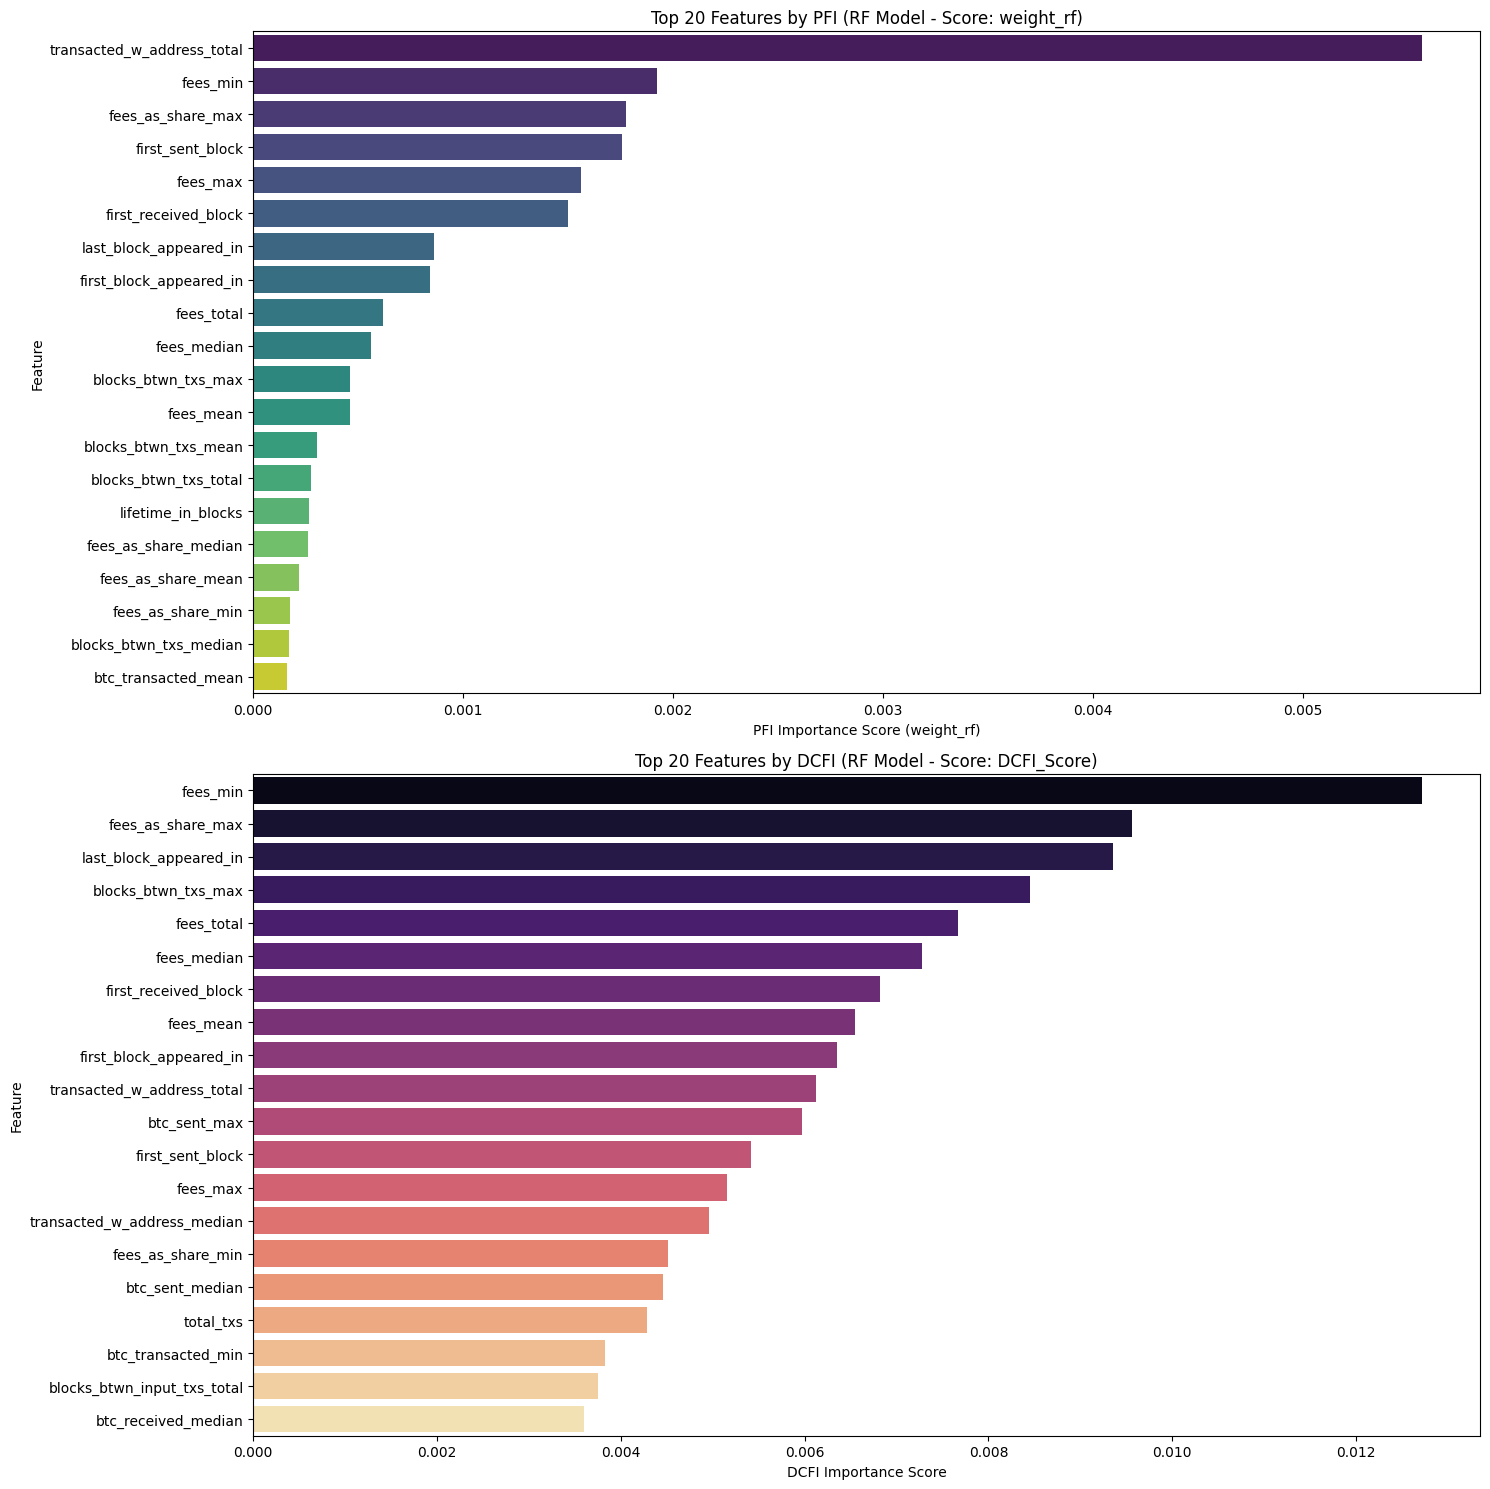

In [21]:
# Cell 17 - Visualizing PFI and DCFI Separately (Adjusted for your column names)
import matplotlib.pyplot as plt
import seaborn as sns

num_features_to_plot = 20

# --- Individual PFI Scores ---
# pfi_rf_df has 'Feature' and 'weight_rf'
top_pfi_features_df = pfi_rf_df.sort_values(by='weight_rf', ascending=False).head(num_features_to_plot)

# --- Individual DCFI Scores ---
# dcfi_rf_df has 'Feature' and 'DCFI_Score'
top_dcfi_features_df = dcfi_rf_df.sort_values(by='DCFI_Score', ascending=False).head(num_features_to_plot)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Plot Top PFI Features
sns.barplot(x='weight_rf', y='Feature', data=top_pfi_features_df, ax=axes[0], palette="viridis", orient='h')
axes[0].set_title(f'Top {num_features_to_plot} Features by PFI (RF Model - Score: weight_rf)')
axes[0].set_xlabel("PFI Importance Score (weight_rf)")
axes[0].set_ylabel("Feature")

# Plot Top DCFI Features
sns.barplot(x='DCFI_Score', y='Feature', data=top_dcfi_features_df, ax=axes[1], palette="magma", orient='h')
axes[1].set_title(f'Top {num_features_to_plot} Features by DCFI (RF Model - Score: DCFI_Score)')
axes[1].set_xlabel("DCFI Importance Score")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

In [26]:
num_top_features_each_method = 20

top_pfi_list = pfi_rf_df.sort_values(by='weight_rf', ascending=False).head(num_top_features_each_method)['Feature'].tolist()
top_dcfi_list = dcfi_rf_df.sort_values(by='DCFI_Score', ascending=False).head(num_top_features_each_method)['Feature'].tolist()

selected_features_union = list(set(top_pfi_list + top_dcfi_list)) # Get unique features from both lists

print(f"\nNumber of features in top {num_top_features_each_method} PFI list: {len(top_pfi_list)}")
print(f"Features from PFI top {num_top_features_each_method}: {top_pfi_list}") 

print(f"\nNumber of features in top {num_top_features_each_method} DCFI list: {len(top_dcfi_list)}")
print(f"Features from DCFI top {num_top_features_each_method}: {top_dcfi_list}")

print(f"\nNumber of unique features from the union of top {num_top_features_each_method} PFI and DCFI: {len(selected_features_union)}")
print(f"Selected features (union): {selected_features_union}")


Number of features in top 20 PFI list: 20
Features from PFI top 20: ['transacted_w_address_total', 'fees_min', 'fees_as_share_max', 'first_sent_block', 'fees_max', 'first_received_block', 'last_block_appeared_in', 'first_block_appeared_in', 'fees_total', 'fees_median', 'blocks_btwn_txs_max', 'fees_mean', 'blocks_btwn_txs_mean', 'blocks_btwn_txs_total', 'lifetime_in_blocks', 'fees_as_share_median', 'fees_as_share_mean', 'fees_as_share_min', 'blocks_btwn_txs_median', 'btc_transacted_mean']

Number of features in top 20 DCFI list: 20
Features from DCFI top 20: ['fees_min', 'fees_as_share_max', 'last_block_appeared_in', 'blocks_btwn_txs_max', 'fees_total', 'fees_median', 'first_received_block', 'fees_mean', 'first_block_appeared_in', 'transacted_w_address_total', 'btc_sent_max', 'first_sent_block', 'fees_max', 'transacted_w_address_median', 'fees_as_share_min', 'btc_sent_median', 'total_txs', 'btc_transacted_min', 'blocks_btwn_input_txs_total', 'btc_received_median']

Number of unique fea

## Features of 2 methods

In [23]:
# Uses 'selected_features_union' from the previous cell - combine features from 2 methods

X_train_selected_rf_union = X_train_scaled[selected_features_union].copy()
X_test_selected_rf_union = X_test_scaled[selected_features_union].copy()

X_train_selected_rf_union

,lifetime_in_blocks,blocks_btwn_input_txs_total,transacted_w_address_median,blocks_btwn_txs_max,total_txs,btc_received_median,fees_as_share_mean,fees_max,first_block_appeared_in,blocks_btwn_txs_median,...,btc_sent_max,transacted_w_address_total,fees_mean,fees_as_share_min,fees_median,first_received_block,first_sent_block,fees_total,fees_min,btc_transacted_mean
0,0.000000,0.0,0.0,0.000000,0.00000,7.201635e-06,1.197680e-04,0.024699,0.499985,0.000000,...,0.000000,0.000608,0.024699,1.197680e-04,0.024699,0.900837,0.000000,0.003340,0.024699,4.852314e-06
1,0.000000,0.0,0.0,0.000000,0.00000,7.025390e-08,1.474244e-05,0.096798,0.416657,0.000000,...,0.000000,0.000000,0.096798,1.474244e-05,0.096798,0.884312,0.000000,0.013092,0.096798,4.733564e-08
2,0.000000,0.0,0.0,0.000000,0.00000,2.819778e-07,2.935653e-05,0.004712,0.395898,0.000000,...,0.000000,0.000106,0.004712,2.935653e-05,0.004712,0.880195,0.000000,0.000637,0.004712,1.899909e-07
3,0.000021,0.0,0.0,0.000021,0.00068,3.909771e-05,1.415049e-04,0.000351,0.083379,0.000021,...,0.000024,0.000053,0.000351,9.792967e-05,0.000351,0.818216,0.818220,0.000095,0.000351,5.268646e-05
4,0.000000,0.0,0.0,0.000000,0.00000,6.776039e-06,1.825530e-05,0.004041,0.333371,0.000000,...,0.000000,0.000264,0.004041,1.825530e-05,0.004041,0.867794,0.000000,0.000547,0.004041,4.565556e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185742,0.000000,0.0,0.0,0.000000,0.00000,4.742545e-04,6.297921e-05,0.011598,0.895841,0.000000,...,0.000000,0.000000,0.011598,6.297921e-05,0.011598,0.979343,0.000000,0.001569,0.011598,3.195429e-04
185743,0.000000,0.0,0.0,0.000000,0.00000,7.274071e-07,3.273296e-05,0.028156,0.729207,0.000000,...,0.000000,0.000370,0.028156,3.273296e-05,0.028156,0.946296,0.000000,0.003808,0.028156,4.901119e-07
185744,0.000000,0.0,0.0,0.000000,0.00000,0.000000e+00,3.982008e-04,0.350214,0.624986,0.000000,...,0.000002,0.000026,0.350214,3.982008e-04,0.350214,0.000000,0.925627,0.047365,0.350214,4.436803e-06
185745,0.000000,0.0,0.0,0.000000,0.00000,1.005140e-05,4.939010e-03,0.003279,0.145885,0.000000,...,0.000000,0.000238,0.003279,4.939010e-03,0.003279,0.830612,0.000000,0.000443,0.003279,6.772425e-06


In [32]:
import pandas as pd

merged_scores_for_ranking = pd.merge(
    pfi_rf_df.rename(columns={'weight_rf': 'PFI_Score'}),
    dcfi_rf_df,
    on='Feature',
    how='outer'
).fillna(0)

merged_scores_for_ranking['Mean_PFI_DCFI_Score'] = merged_scores_for_ranking[['PFI_Score', 'DCFI_Score']].mean(axis=1)

ranked_features_in_union_df = merged_scores_for_ranking[
    merged_scores_for_ranking['Feature'].isin(selected_features_union)
].sort_values('Mean_PFI_DCFI_Score', ascending=False)

ranked_union_feature_list_for_optuna = ranked_features_in_union_df['Feature'].tolist()

min_features_to_try_optuna = 5
max_features_to_try_optuna = len(ranked_union_feature_list_for_optuna)

if min_features_to_try_optuna > max_features_to_try_optuna:
    min_features_to_try_optuna = max_features_to_try_optuna if max_features_to_try_optuna > 0 else 0
if max_features_to_try_optuna == 0: # Ensure min is also 0 if max is 0 (empty list)
     min_features_to_try_optuna = 0

## Features from only PFI method

In [24]:

X_train_selected_pfi = X_train_scaled[top_pfi_list].copy()
X_test_selected_pfi = X_test_scaled[top_pfi_list].copy()

X_train_selected_pfi

,transacted_w_address_total,fees_min,fees_as_share_max,first_sent_block,fees_max,first_received_block,last_block_appeared_in,first_block_appeared_in,fees_total,fees_median,blocks_btwn_txs_max,fees_mean,blocks_btwn_txs_mean,blocks_btwn_txs_total,lifetime_in_blocks,fees_as_share_median,fees_as_share_mean,fees_as_share_min,blocks_btwn_txs_median,btc_transacted_mean
0,0.000608,0.024699,1.048422e-04,0.000000,0.024699,0.900837,0.499985,0.499985,0.003340,0.024699,0.000000,0.024699,0.000000,0.000000,0.000000,1.197680e-04,1.197680e-04,1.197680e-04,0.000000,4.852314e-06
1,0.000000,0.096798,1.290520e-05,0.000000,0.096798,0.884312,0.416657,0.416657,0.013092,0.096798,0.000000,0.096798,0.000000,0.000000,0.000000,1.474244e-05,1.474244e-05,1.474244e-05,0.000000,4.733564e-08
2,0.000106,0.004712,2.569805e-05,0.000000,0.004712,0.880195,0.395898,0.395898,0.000637,0.004712,0.000000,0.004712,0.000000,0.000000,0.000000,2.935653e-05,2.935653e-05,2.935653e-05,0.000000,1.899909e-07
3,0.000053,0.000351,1.620151e-04,0.818220,0.000351,0.818216,0.083400,0.083379,0.000095,0.000351,0.000021,0.000351,0.000021,0.000021,0.000021,1.415049e-04,1.415049e-04,9.792967e-05,0.000021,5.268646e-05
4,0.000264,0.004041,1.598027e-05,0.000000,0.004041,0.867794,0.333371,0.333371,0.000547,0.004041,0.000000,0.004041,0.000000,0.000000,0.000000,1.825530e-05,1.825530e-05,1.825530e-05,0.000000,4.565556e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185742,0.000000,0.011598,5.513058e-05,0.000000,0.011598,0.979343,0.895841,0.895841,0.001569,0.011598,0.000000,0.011598,0.000000,0.000000,0.000000,6.297921e-05,6.297921e-05,6.297921e-05,0.000000,3.195429e-04
185743,0.000370,0.028156,2.865370e-05,0.000000,0.028156,0.946296,0.729207,0.729207,0.003808,0.028156,0.000000,0.028156,0.000000,0.000000,0.000000,3.273296e-05,3.273296e-05,3.273296e-05,0.000000,4.901119e-07
185744,0.000026,0.350214,3.485760e-04,0.925627,0.350214,0.000000,0.624986,0.624986,0.047365,0.350214,0.000000,0.350214,0.000000,0.000000,0.000000,3.982008e-04,3.982008e-04,3.982008e-04,0.000000,4.436803e-06
185745,0.000238,0.003279,4.323498e-03,0.000000,0.003279,0.830612,0.145885,0.145885,0.000443,0.003279,0.000000,0.003279,0.000000,0.000000,0.000000,4.939010e-03,4.939010e-03,4.939010e-03,0.000000,6.772425e-06


## Feature from only DCFI method

In [25]:
X_train_selected_dcfi = X_train_scaled[top_dcfi_list].copy()
X_test_selected_dcfi = X_test_scaled[top_dcfi_list].copy()
X_train_selected_dcfi

,fees_min,fees_as_share_max,last_block_appeared_in,blocks_btwn_txs_max,fees_total,fees_median,first_received_block,fees_mean,first_block_appeared_in,transacted_w_address_total,btc_sent_max,first_sent_block,fees_max,transacted_w_address_median,fees_as_share_min,btc_sent_median,total_txs,btc_transacted_min,blocks_btwn_input_txs_total,btc_received_median
0,0.024699,1.048422e-04,0.499985,0.000000,0.003340,0.024699,0.900837,0.024699,0.499985,0.000608,0.000000,0.000000,0.024699,0.0,1.197680e-04,0.000000,0.00000,5.314050e-06,0.0,7.201635e-06
1,0.096798,1.290520e-05,0.416657,0.000000,0.013092,0.096798,0.884312,0.096798,0.416657,0.000000,0.000000,0.000000,0.096798,0.0,1.474244e-05,0.000000,0.00000,5.184000e-08,0.0,7.025390e-08
2,0.004712,2.569805e-05,0.395898,0.000000,0.000637,0.004712,0.880195,0.004712,0.395898,0.000106,0.000000,0.000000,0.004712,0.0,2.935653e-05,0.000000,0.00000,2.080700e-07,0.0,2.819778e-07
3,0.000351,1.620151e-04,0.083400,0.000021,0.000095,0.000351,0.818216,0.000351,0.083379,0.000053,0.000024,0.818220,0.000351,0.0,9.792967e-05,0.000029,0.00068,5.770000e-05,0.0,3.909771e-05
4,0.004041,1.598027e-05,0.333371,0.000000,0.000547,0.004041,0.867794,0.004041,0.333371,0.000264,0.000000,0.000000,0.004041,0.0,1.825530e-05,0.000000,0.00000,5.000005e-06,0.0,6.776039e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185742,0.011598,5.513058e-05,0.895841,0.000000,0.001569,0.011598,0.979343,0.011598,0.895841,0.000000,0.000000,0.000000,0.011598,0.0,6.297921e-05,0.000000,0.00000,3.499500e-04,0.0,4.742545e-04
185743,0.028156,2.865370e-05,0.729207,0.000000,0.003808,0.028156,0.946296,0.028156,0.729207,0.000370,0.000000,0.000000,0.028156,0.0,3.273296e-05,0.000000,0.00000,5.367500e-07,0.0,7.274071e-07
185744,0.350214,3.485760e-04,0.624986,0.000000,0.047365,0.350214,0.000000,0.350214,0.624986,0.000026,0.000002,0.925627,0.350214,0.0,3.982008e-04,0.000005,0.00000,4.859000e-06,0.0,0.000000e+00
185745,0.003279,4.323498e-03,0.145885,0.000000,0.000443,0.003279,0.830612,0.003279,0.145885,0.000238,0.000000,0.000000,0.003279,0.0,4.939010e-03,0.000000,0.00000,7.416875e-06,0.0,1.005140e-05


# Retrain model

## Retrain model with top 27 features (merged), using optuna

In [33]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def objective_rf_hyper_and_k_from_ranked_union(trial,
                                               X_train_full_df, y_train_np,
                                               X_test_full_df, y_test_np,
                                               ranked_candidate_features,
                                               min_k, max_k):
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'random_state': 42,
        'n_jobs': -1
    }

    if max_k == 0 or min_k > max_k:
        return 0.0
    
    if min_k == max_k:
        num_selected_features = min_k
    else:
        num_selected_features = trial.suggest_int('k_features', min_k, max_k)

    current_features_to_use = ranked_candidate_features[:num_selected_features]

    if not current_features_to_use: # Should only happen if min_k=0 and num_selected_features=0
        return 0.0

    X_train_subset = X_train_full_df[current_features_to_use]
    X_test_subset = X_test_full_df[current_features_to_use]

    model_rf = RandomForestClassifier(**rf_params)
    model_rf.fit(X_train_subset, y_train_np)
    y_pred = model_rf.predict(X_test_subset)
    
    f1 = f1_score(y_test_np, y_pred, pos_label=1, average='binary', zero_division=0)
    return f1   

In [34]:
study_rf_final = optuna.create_study(direction='maximize')
if max_features_to_try_optuna > 0 and min_features_to_try_optuna <= max_features_to_try_optuna:
    study_rf_final.optimize(
        lambda trial: objective_rf_hyper_and_k_from_ranked_union(
            trial,
            X_train_scaled, y_train,
            X_test_scaled, y_test,
            ranked_union_feature_list_for_optuna,
            min_features_to_try_optuna,
            max_features_to_try_optuna
        ),
        n_trials=50 
    )

    best_trial_final = study_rf_final.best_trial
    best_rf_params_final = {k: v for k, v in best_trial_final.params.items() if k != 'k_features'}
    best_k_features_final = best_trial_final.params.get('k_features', 0) # Lấy k_features, mặc định là 0 nếu không có
    print(f"Best F1-score (class 1) from Optuna: {best_trial_final.value}")
    print(f"Best number of features to select: {best_k_features_final}")
    print(f"Best RF hyperparameters: {best_rf_params_final}")

    final_selected_features_from_optuna = []
    if best_k_features_final > 0 and ranked_union_feature_list_for_optuna:
         final_selected_features_from_optuna = ranked_union_feature_list_for_optuna[:best_k_features_final]
    
    if final_selected_features_from_optuna: # Chỉ huấn luyện nếu có features được chọn
        X_train_final_optuna = X_train_scaled[final_selected_features_from_optuna]
        X_test_final_optuna = X_test_scaled[final_selected_features_from_optuna]
    else:
        print("\nFinal model training skipped: No features were selected by Optuna.")

else:
    print("\nOptuna study skipped: No features available or invalid min/max k.")


[I 2025-06-05 08:51:58,197] A new study created in memory with name: no-name-04be0e44-8378-4143-bedd-aed380228e0e
[I 2025-06-05 08:52:04,696] Trial 0 finished with value: 0.6966014418125644 and parameters: {'n_estimators': 70, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 8, 'class_weight': None, 'k_features': 10}. Best is trial 0 with value: 0.6966014418125644.
[I 2025-06-05 08:52:25,684] Trial 1 finished with value: 0.6367406684557209 and parameters: {'n_estimators': 153, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'k_features': 20}. Best is trial 0 with value: 0.6966014418125644.
[I 2025-06-05 08:53:07,724] Trial 2 finished with value: 0.7880307065643114 and parameters: {'n_estimators': 242, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample', 'k_features': 18}. Best is trial 2 with value: 0.7880307065643114.
[I 2025-06-05 08:53:16,565] Trial 3 finished with value: 0.521

Best F1-score (class 1) from Optuna: 0.8575576120486299
Best number of features to select: 16
Best RF hyperparameters: {'n_estimators': 220, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 1, 'class_weight': None}

 Final Tuned RF (Optuna Selected k & HPs) Evaluation Results:
ROC AUC: 0.991962

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.997     0.995     76718
           1      0.901     0.818     0.858      2889

    accuracy                          0.990     79607
   macro avg      0.947     0.907     0.926     79607
weighted avg      0.990     0.990     0.990     79607



In [38]:
final_selected_features_from_optuna

['fees_min',
 'transacted_w_address_total',
 'fees_as_share_max',
 'last_block_appeared_in',
 'blocks_btwn_txs_max',
 'first_received_block',
 'fees_total',
 'fees_median',
 'first_block_appeared_in',
 'first_sent_block',
 'fees_mean',
 'fees_max',
 'btc_sent_max',
 'transacted_w_address_median',
 'fees_as_share_min',
 'total_txs']

In [35]:
final_rf_model = RandomForestClassifier(**best_rf_params_final, random_state=42, n_jobs=-1)
final_rf_model.fit(X_train_final_optuna, y_train)
y_pred_final_proba = final_rf_model.predict_proba(X_test_final_optuna)[:, 1]
y_pred_final = final_rf_model.predict(X_test_final_optuna)

evaluate_model( 
    "Final Tuned RF (Optuna Selected k & HPs)",
    y_test,
    y_pred_final,
    y_proba=y_pred_final_proba
)


 Final Tuned RF (Optuna Selected k & HPs) Evaluation Results:
ROC AUC: 0.991962

Classification Report:
              precision    recall  f1-score   support

           0      0.993     0.997     0.995     76718
           1      0.901     0.818     0.858      2889

    accuracy                          0.990     79607
   macro avg      0.947     0.907     0.926     79607
weighted avg      0.990     0.990     0.990     79607



In [36]:
import optuna
from xgboost import XGBClassifier # Đảm bảo đã import XGBClassifier
from sklearn.metrics import f1_score

# Giả sử X_train_scaled, y_train, X_test_scaled, y_test,
# ranked_union_feature_list_for_optuna, min_features_to_try_optuna,
# và max_features_to_try_optuna đã được định nghĩa từ các cell trước.
# Giả sử hàm evaluate_model đã được định nghĩa ở cell 13.


def objective_xgb_hyper_and_k_from_ranked_union(trial,
                                               X_train_full_df, y_train_np,
                                               X_test_full_df, y_test_np,
                                               ranked_candidate_features,
                                               min_k, max_k):
    # --- Đề xuất các siêu tham số cho XGBoost ---
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        # Giữ các tham số cố định này để nhất quán và tránh warning
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1
    }

    # --- Đề xuất số lượng features (k) ---
    if max_k == 0 or min_k > max_k:
        return 0.0
    
    if min_k == max_k:
        num_selected_features = min_k
    else:
        num_selected_features = trial.suggest_int('k_features', min_k, max_k)

    current_features_to_use = ranked_candidate_features[:num_selected_features]

    if not current_features_to_use:
        return 0.0

    X_train_subset = X_train_full_df[current_features_to_use]
    X_test_subset = X_test_full_df[current_features_to_use]

    model_xgb = XGBClassifier(**xgb_params)
    model_xgb.fit(X_train_subset, y_train_np)
    y_pred = model_xgb.predict(X_test_subset)
    
    f1 = f1_score(y_test_np, y_pred, pos_label=1, average='binary', zero_division=0)
    return f1

# --- Bắt đầu Optuna study cho XGBoost ---
print("\nStarting Optuna study for XGBoost (HPs & k features from ranked union pool)...")
study_xgb_final = optuna.create_study(direction='maximize')

if max_features_to_try_optuna > 0 and min_features_to_try_optuna <= max_features_to_try_optuna:
    study_xgb_final.optimize(
        lambda trial: objective_xgb_hyper_and_k_from_ranked_union(
            trial,
            X_train_scaled, y_train,
            X_test_scaled, y_test,
            ranked_union_feature_list_for_optuna,
            min_features_to_try_optuna,
            max_features_to_try_optuna
        ),
        n_trials=50 # Điều chỉnh nếu cần, ví dụ: 50-100
    )

    best_trial_xgb_final = study_xgb_final.best_trial
    best_xgb_params_final = {k: v for k, v in best_trial_xgb_final.params.items() if k != 'k_features'}
    best_k_features_xgb_final = best_trial_xgb_final.params.get('k_features', 0)

    print(f"\nBest F1-score (class 1) for XGBoost from Optuna: {best_trial_xgb_final.value}")
    print(f"Best number of features to select for XGBoost: {best_k_features_xgb_final}")
    print(f"Best XGBoost hyperparameters for this k: {best_xgb_params_final}")

    # --- Huấn luyện lại và đánh giá mô hình XGBoost cuối cùng ---
    final_selected_features_xgb_optuna = []
    if best_k_features_xgb_final > 0 and ranked_union_feature_list_for_optuna:
         final_selected_features_xgb_optuna = ranked_union_feature_list_for_optuna[:best_k_features_xgb_final]
    
    if final_selected_features_xgb_optuna:
        X_train_final_xgb_optuna = X_train_scaled[final_selected_features_xgb_optuna]
        X_test_final_xgb_optuna = X_test_scaled[final_selected_features_xgb_optuna]

    else:
        print("\nFinal XGBoost model training skipped: No features were selected by Optuna.")

else:
    print("\nOptuna study for XGBoost skipped: No features available or invalid min/max k.")

[I 2025-06-05 09:20:48,449] A new study created in memory with name: no-name-51625e74-c31d-41c2-9426-1c4ac8182fbc



Starting Optuna study for XGBoost (HPs & k features from ranked union pool)...


[I 2025-06-05 09:20:51,668] Trial 0 finished with value: 0.8201008780123294 and parameters: {'n_estimators': 276, 'learning_rate': 0.048220875265906994, 'max_depth': 6, 'subsample': 0.85968338901798, 'colsample_bytree': 0.7399377424399983, 'gamma': 0.5240315658844358, 'reg_alpha': 0.40882875534899354, 'reg_lambda': 4.875251289026674e-08, 'k_features': 16}. Best is trial 0 with value: 0.8201008780123294.
[I 2025-06-05 09:20:52,626] Trial 1 finished with value: 0.43813493097160716 and parameters: {'n_estimators': 101, 'learning_rate': 0.030063639606706008, 'max_depth': 3, 'subsample': 0.746560580359935, 'colsample_bytree': 0.9535265515341127, 'gamma': 4.150814020806356, 'reg_alpha': 1.2487939701619274e-06, 'reg_lambda': 6.158662314918449e-05, 'k_features': 12}. Best is trial 0 with value: 0.8201008780123294.
[I 2025-06-05 09:20:53,869] Trial 2 finished with value: 0.4454193548387097 and parameters: {'n_estimators': 193, 'learning_rate': 0.023757775013572215, 'max_depth': 3, 'subsample': 


Best F1-score (class 1) for XGBoost from Optuna: 0.8726228919985648
Best number of features to select for XGBoost: 18
Best XGBoost hyperparameters for this k: {'n_estimators': 171, 'learning_rate': 0.1596135915025657, 'max_depth': 10, 'subsample': 0.8606391378685939, 'colsample_bytree': 0.8812610595638292, 'gamma': 0.6662590744450073, 'reg_alpha': 4.4320337218503477e-07, 'reg_lambda': 0.0002448945321397445}


In [37]:

print(f"\nTraining final XGBoost model with {best_k_features_xgb_final} selected features and tuned hyperparameters...")
final_xgb_model = XGBClassifier(
    **best_xgb_params_final,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
final_xgb_model.fit(X_train_final_xgb_optuna, y_train)

y_pred_final_xgb_proba = final_xgb_model.predict_proba(X_test_final_xgb_optuna)[:, 1]
y_pred_final_xgb = final_xgb_model.predict(X_test_final_xgb_optuna)

evaluate_model(
    "Final Tuned XGBoost (Optuna Selected k & HPs)",
    y_test,
    y_pred_final_xgb,
    y_proba=y_pred_final_xgb_proba
)


Training final XGBoost model with 18 selected features and tuned hyperparameters...

 Final Tuned XGBoost (Optuna Selected k & HPs) Evaluation Results:
ROC AUC: 0.994829

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.997     0.995     76718
           1      0.906     0.842     0.873      2889

    accuracy                          0.991     79607
   macro avg      0.950     0.919     0.934     79607
weighted avg      0.991     0.991     0.991     79607



In [39]:
final_selected_features_xgb_optuna

['fees_min',
 'transacted_w_address_total',
 'fees_as_share_max',
 'last_block_appeared_in',
 'blocks_btwn_txs_max',
 'first_received_block',
 'fees_total',
 'fees_median',
 'first_block_appeared_in',
 'first_sent_block',
 'fees_mean',
 'fees_max',
 'btc_sent_max',
 'transacted_w_address_median',
 'fees_as_share_min',
 'total_txs',
 'btc_sent_median',
 'btc_transacted_min']